In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error

In [120]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [121]:
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   login                    5725 non-null   int64  
 1   country                  5725 non-null   object 
 2   account_currency         5725 non-null   object 
 3   Trading_Frequency        5725 non-null   float64
 4   Buy_Percentage           5725 non-null   float64
 5   Average_Volume           5725 non-null   float64
 6   Average_Volume_USD       5725 non-null   float64
 7   Average_DPM              5725 non-null   float64
 8   Unique_Symbols_Traded    5725 non-null   int64  
 9   Peak_Trading_Times       5725 non-null   int64  
 10  Ratio_Profitable_Trades  5725 non-null   float64
 11  Profit_Loss_Variability  5725 non-null   float64
 12  Average_Trade_Duration   5725 non-null   float64
 13  TP/SL Hit Ratio          5725 non-null   float64
 14  Reward_Risk_Ratio       

In [122]:
# Convert 'country', 'account_currency', and 'Trading_Method' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')

# Convert 'active' column to categorical
modelling_df['active'] = modelling_df['active'].astype('category')

## Correlation Analysis

In [92]:
numeric_cols = modelling_df.select_dtypes(include=['int64', 'float64']).columns

# Creating a new DataFrame with only numeric columns
df_numeric = modelling_df[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

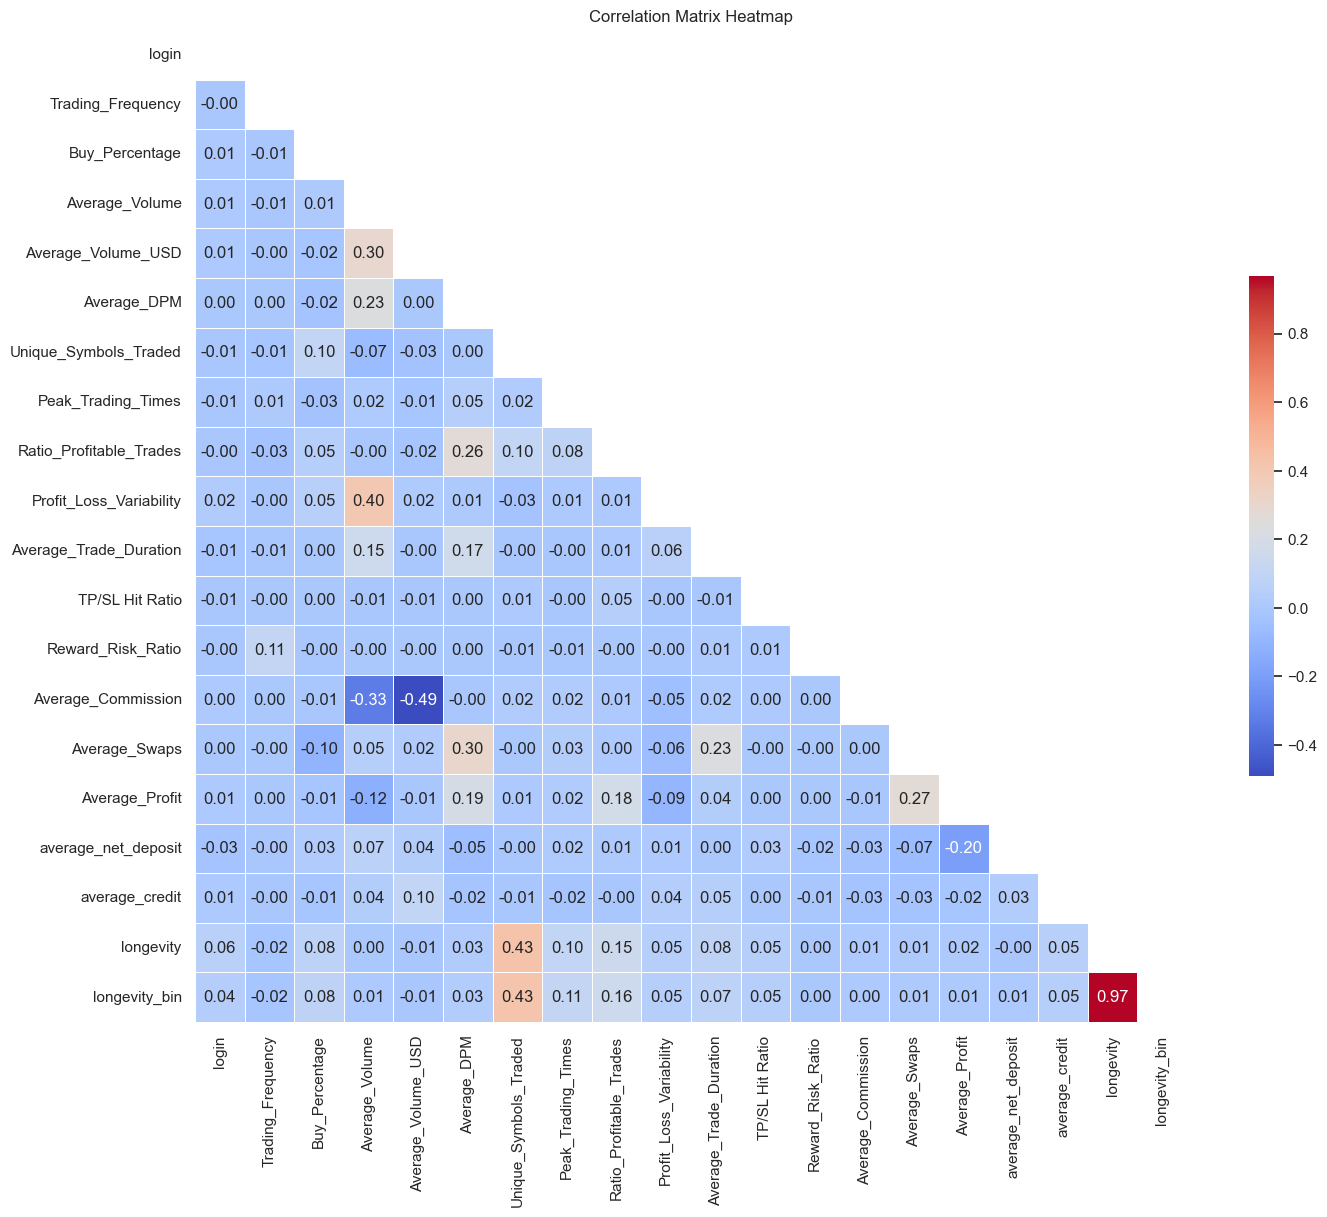

In [93]:
# Setting up the aesthetics for the heatmap
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 13))

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                      square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

## Modelling Preprocessing

In [123]:
# Remove specified columns and set 'longevity_bin' as the target variable
features_df = modelling_df.drop(columns=['login', 'active', 'Unique_Symbols_Traded', 'Average_Volume', 'longevity', 'longevity_bin'])
y = modelling_df['longevity_bin']

In [124]:
# List of all numeric columns
all_numeric_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(features_df)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)
X_preprocessed_df.head()

,Trading_Frequency,Average_Volume_USD,Average_DPM,Peak_Trading_Times,Profit_Loss_Variability,Average_Trade_Duration,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,average_credit,Buy_Percentage,TP/SL Hit Ratio,Reward_Risk_Ratio,Ratio_Profitable_Trades,country,account_currency,Trading_Method
0,1.219451,18.389751,0.133754,0.285714,3.769439,0.383635,-6.935588,-24.382993,1.632630,14.078065,0.0,0.474856,3.375000,0.086763,0.762931,6.0,3.0,1.0
1,3.003094,-0.016366,-0.376042,0.285714,-0.158953,0.766293,0.000000,-1.832092,0.056110,0.572981,0.0,0.496354,0.087081,-0.549598,0.718323,41.0,7.0,2.0
2,0.470264,-0.016545,-6.507861,0.285714,-0.149662,0.579659,0.000000,0.035756,-0.502678,0.006259,0.0,0.159420,0.000000,0.000000,0.463768,115.0,6.0,1.0
3,1.159722,-0.016422,0.174810,-1.714286,-0.221091,-0.135303,0.000000,-0.381555,0.074743,-0.274993,0.0,0.635294,0.000000,0.000000,0.517647,76.0,7.0,2.0
4,-0.197506,0.007317,0.051715,-1.714286,-0.263700,0.134139,-0.101129,-0.160496,0.093413,0.042457,0.0,0.512397,0.002283,55.989328,0.311983,5.0,0.0,2.0


## Model Splitting

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42, stratify=y)


## Model Comparison

In [145]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC())
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("nn", MLPClassifier(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Adding XGBoost with specific parameters to avoid warnings and adapt to multi-class settings
}

Classification Report for Logistic Regression after SMOTE (MAE: 0.5983):

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       715
           1       0.31      0.09      0.14       243
           2       0.67      0.03      0.06       119
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14

    accuracy                           0.63      1145
   macro avg       0.27      0.18      0.16      1145
weighted avg       0.54      0.63      0.52      1145



C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: Undefin

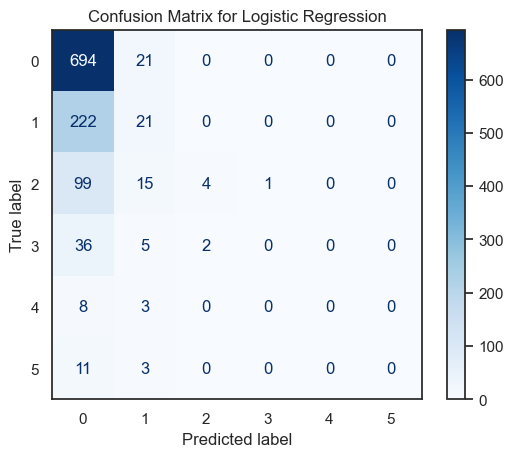

Classification Report for Decision Tree after SMOTE (MAE: 0.5677):

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       715
           1       0.32      0.30      0.31       243
           2       0.26      0.29      0.27       119
           3       0.13      0.16      0.15        43
           4       0.00      0.00      0.00        11
           5       0.33      0.14      0.20        14

    accuracy                           0.61      1145
   macro avg       0.31      0.28      0.29      1145
weighted avg       0.61      0.61      0.61      1145



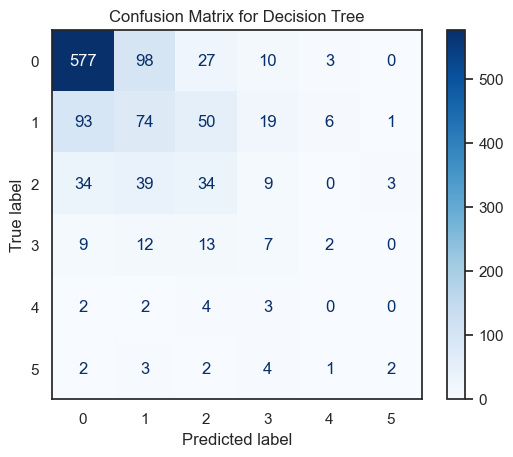

Classification Report for SVM after SMOTE (MAE: 0.6175):

              precision    recall  f1-score   support

           0       0.63      0.99      0.77       715
           1       0.30      0.03      0.05       243
           2       0.67      0.02      0.03       119
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14

    accuracy                           0.63      1145
   macro avg       0.27      0.17      0.14      1145
weighted avg       0.53      0.63      0.50      1145



C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

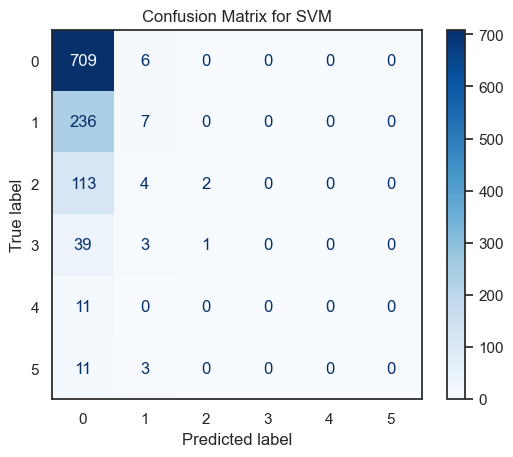

Classification Report for KNN after SMOTE (MAE: 0.6009):

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       715
           1       0.33      0.26      0.29       243
           2       0.30      0.13      0.18       119
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14

    accuracy                           0.61      1145
   macro avg       0.22      0.21      0.21      1145
weighted avg       0.54      0.61      0.57      1145



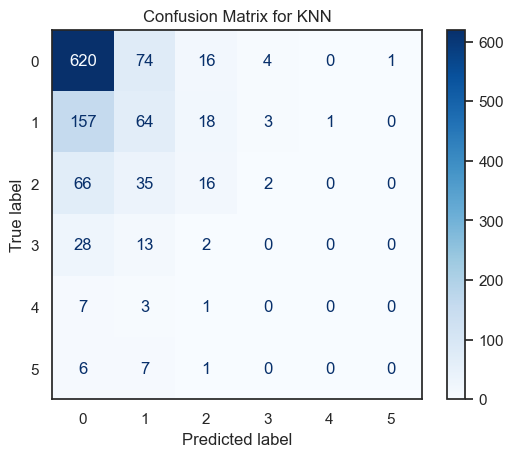

Classification Report for Neural Network after SMOTE (MAE: 0.5389):

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       715
           1       0.36      0.30      0.33       243
           2       0.32      0.18      0.23       119
           3       0.33      0.07      0.12        43
           4       0.50      0.09      0.15        11
           5       0.00      0.00      0.00        14

    accuracy                           0.64      1145
   macro avg       0.38      0.25      0.27      1145
weighted avg       0.59      0.64      0.61      1145



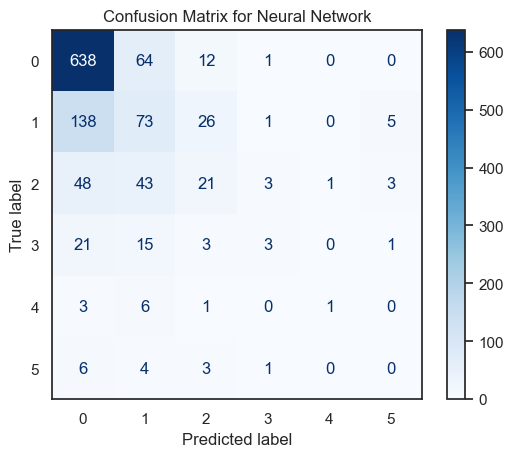

Classification Report for Random Forest after SMOTE (MAE: 0.4271):

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       715
           1       0.42      0.41      0.42       243
           2       0.40      0.17      0.24       119
           3       0.14      0.02      0.04        43
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14

    accuracy                           0.70      1145
   macro avg       0.29      0.26      0.26      1145
weighted avg       0.63      0.70      0.65      1145



C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

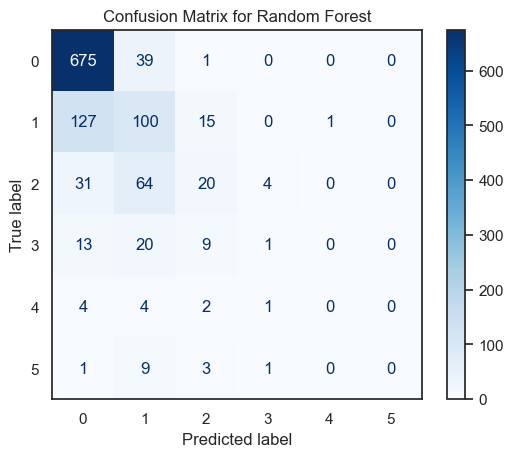

Classification Report for XGBoost after SMOTE (MAE: 0.3956):

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       715
           1       0.45      0.49      0.47       243
           2       0.36      0.25      0.30       119
           3       0.14      0.05      0.07        43
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14

    accuracy                           0.71      1145
   macro avg       0.30      0.28      0.29      1145
weighted avg       0.66      0.71      0.68      1145



C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

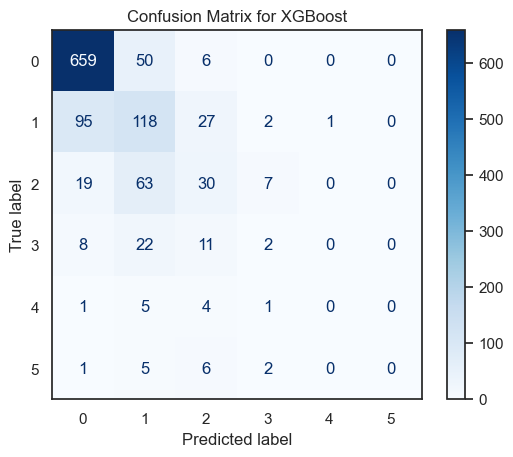

In [146]:
for name, model in models.items():
    model.fit(X_train, y_train)  # Fit model
    y_pred = model.predict(X_test)  # Make predictions on the test set

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Print classification report including MAE
    print(f"Classification Report for {name} (MAE: {mae:.4f}):\n")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

## Sampling Strategy

In [147]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Classification Report for Logistic Regression after SMOTE (MAE: 1.4288):

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       715
           1       0.28      0.17      0.21       243
           2       0.14      0.13      0.13       119
           3       0.08      0.28      0.12        43
           4       0.01      0.09      0.02        11
           5       0.02      0.21      0.04        14

    accuracy                           0.41      1145
   macro avg       0.22      0.24      0.20      1145
weighted avg       0.58      0.41      0.48      1145



C:\Users\Joel Larsen\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


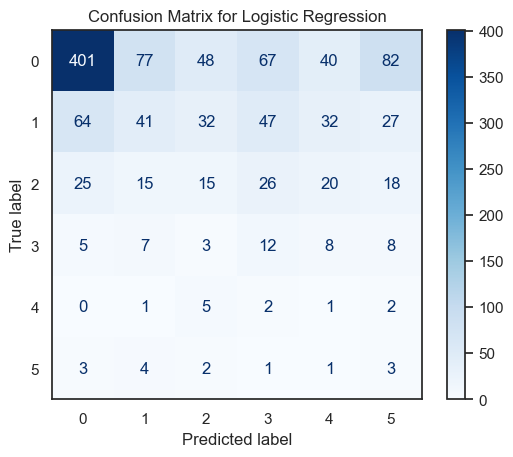

Classification Report for Decision Tree after SMOTE (MAE: 0.5930):

              precision    recall  f1-score   support

           0       0.85      0.77      0.80       715
           1       0.37      0.40      0.38       243
           2       0.26      0.29      0.27       119
           3       0.15      0.19      0.16        43
           4       0.00      0.00      0.00        11
           5       0.05      0.07      0.06        14

    accuracy                           0.60      1145
   macro avg       0.28      0.29      0.28      1145
weighted avg       0.64      0.60      0.62      1145



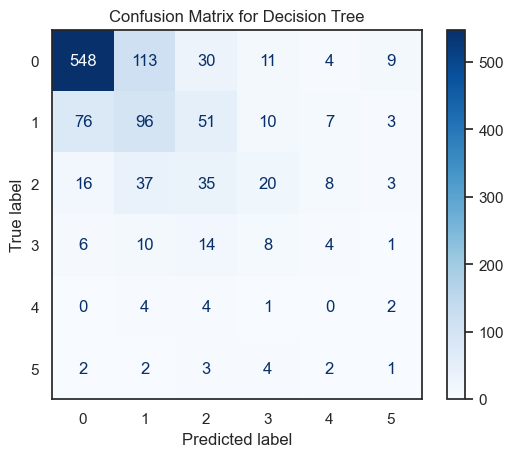

Classification Report for SVM after SMOTE (MAE: 1.0952):

              precision    recall  f1-score   support

           0       0.84      0.69      0.75       715
           1       0.27      0.17      0.21       243
           2       0.13      0.13      0.13       119
           3       0.05      0.14      0.07        43
           4       0.03      0.27      0.06        11
           5       0.01      0.07      0.02        14

    accuracy                           0.49      1145
   macro avg       0.22      0.24      0.21      1145
weighted avg       0.60      0.49      0.53      1145



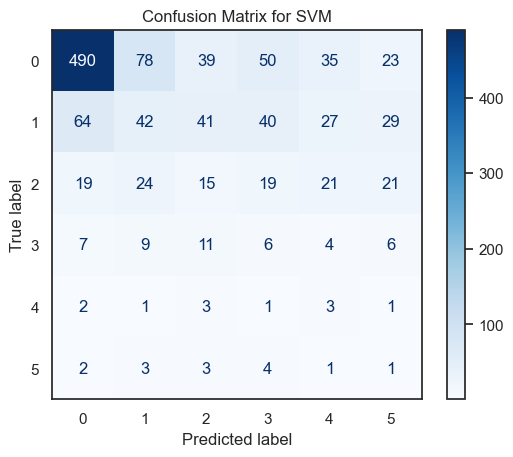

Classification Report for KNN after SMOTE (MAE: 0.8821):

              precision    recall  f1-score   support

           0       0.85      0.63      0.72       715
           1       0.33      0.36      0.35       243
           2       0.14      0.22      0.17       119
           3       0.06      0.12      0.08        43
           4       0.00      0.00      0.00        11
           5       0.02      0.07      0.04        14

    accuracy                           0.50      1145
   macro avg       0.23      0.23      0.23      1145
weighted avg       0.62      0.50      0.55      1145



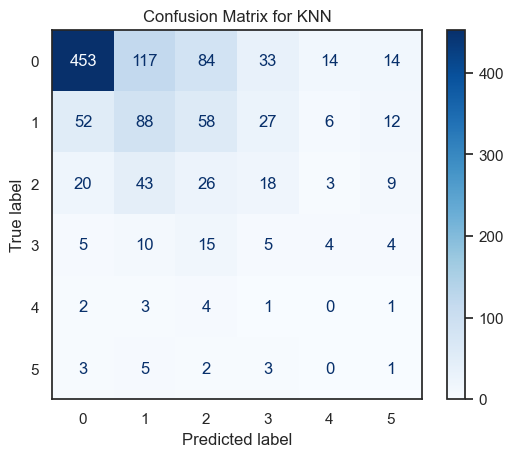

Classification Report for Neural Network after SMOTE (MAE: 0.6428):

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       715
           1       0.36      0.40      0.38       243
           2       0.26      0.36      0.30       119
           3       0.09      0.14      0.11        43
           4       0.00      0.00      0.00        11
           5       0.06      0.07      0.07        14

    accuracy                           0.59      1145
   macro avg       0.27      0.28      0.27      1145
weighted avg       0.65      0.59      0.61      1145



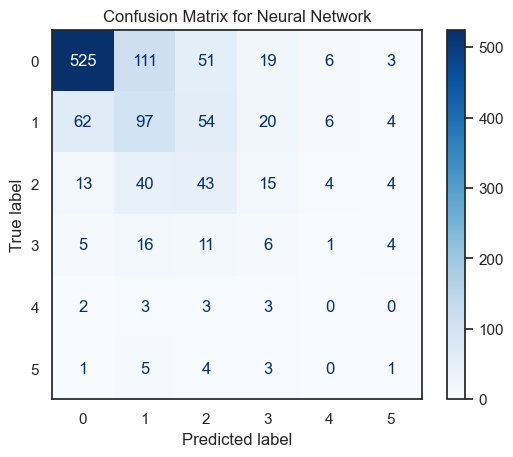

Classification Report for Random Forest after SMOTE (MAE: 0.4463):

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       715
           1       0.43      0.51      0.47       243
           2       0.38      0.30      0.34       119
           3       0.06      0.05      0.05        43
           4       0.00      0.00      0.00        11
           5       0.12      0.07      0.09        14

    accuracy                           0.68      1145
   macro avg       0.31      0.30      0.30      1145
weighted avg       0.67      0.68      0.67      1145



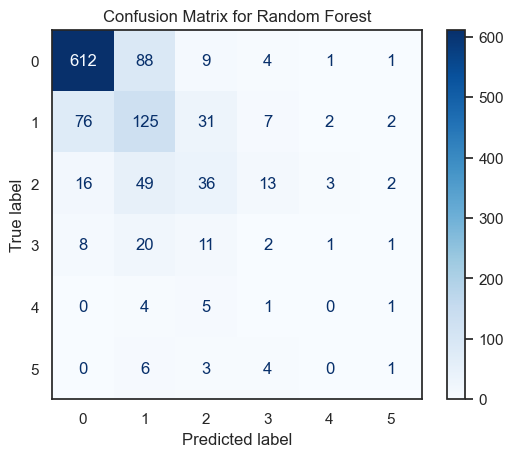

Classification Report for XGBoost after SMOTE (MAE: 0.4009):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       715
           1       0.49      0.48      0.48       243
           2       0.38      0.39      0.38       119
           3       0.22      0.16      0.19        43
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14

    accuracy                           0.71      1145
   macro avg       0.33      0.32      0.32      1145
weighted avg       0.69      0.71      0.70      1145



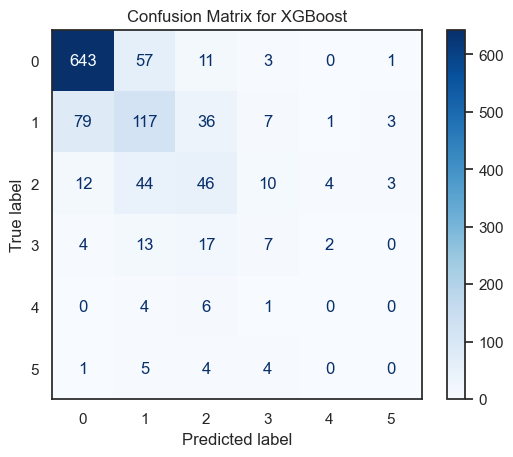

In [148]:
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)  # Train using the resampled dataset
    y_pred1 = model.predict(X_test)  # Predict on the original test set

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred1)

    # Print classification report including MAE
    print(f"Classification Report for {name} after SMOTE (MAE: {mae:.4f}):\n")
    print(classification_report(y_test, y_pred1))

    # Optionally, display the confusion matrix
    cm = confusion_matrix(y_test, y_pred1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()